In [93]:
%matplotlib inline

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import gymnasium as gym
from gymnasium import Env, spaces
from scipy.special import comb
from collections import defaultdict

In [95]:
with open('pickles/anonbank_lognorm_params.pkl', 'rb') as f:
    lognorm_params_df = pickle.load(f)
    
lognorm_params_dict = lognorm_params_df.set_index('param_name').T.to_dict()

lognorm_params_dict

{('1', 'REGULAR'): {'mu': 4.832017135463374,
  'sigma': 0.006958469079704907,
  'loc': -18.81216413263904},
 ('1', 'SPECIFIC'): {'mu': 4.6755415208149325,
  'sigma': 0.011323646523065594,
  'loc': -6.43006717763892},
 ('2', 'REGULAR'): {'mu': 5.0125526231624855,
  'sigma': 0.005548307071802354,
  'loc': -8.97654648869145},
 ('2', 'SPECIFIC'): {'mu': 4.617186601308905,
  'sigma': 0.010134016947128502,
  'loc': -4.806412598886724},
 'REGULAR': {'mu': 3.7589339214345716,
  'sigma': 0.024480564633599006,
  'loc': -2.846758403840244},
 'SPECIFIC': {'mu': 4.650110366782741,
  'sigma': 0.01083819523964822,
  'loc': -5.260938954957395},
 'REGULAR_x4': {'mu': 5.145228282554465,
  'sigma': 0.006121000886257698,
  'loc': -11.387033615361277},
 'SPECIFIC_x4': {'mu': 6.036404727902634,
  'sigma': 0.002709623408600959,
  'loc': -21.043755819830228}}

In [96]:
with open('pickles/anonbank_service_rate.pkl', 'rb') as f:
    service_rate = pickle.load(f)

# Convert service_rate to a dictionary for easier access
ser_rate_dict = service_rate.set_index(['group', 'type_group'])[['mean_service_time', 'std']].to_dict('index')

ser_rate_dict

{('1', 'REGULAR'): {'mean_service_time': 12.641068214208262,
  'std': 274.09685054233046},
 ('1', 'SPECIFIC'): {'mean_service_time': 14.229164478664519,
  'std': 447.916748807343},
 ('2', 'REGULAR'): {'mean_service_time': 19.02417781821472,
  'std': 344.9407640049321},
 ('2', 'SPECIFIC'): {'mean_service_time': 15.020757462895316,
  'std': 257.32365209990894}}

In [97]:

# Global variables

# Queue size
MAX_QUEUE_SIZE = 20

# Discount factor for future rewards
DISCOUNT = 0.95

# Penalty for dropping calls (when queue is full)
DROP_PENALTY = 3600.0 # 1 hour in seconds

# State space: (queue 1 size, queue 2 size, call type)
STATE_SPACE = (MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2)

# Call type: 0 = regular, 1 = specific
CALL_TYPE = [0, 1]

# Actions: 0 = route to queue 1, 1 = route to queue 2
ACTIONS = [1, 2]

# Arrival parameters for regular and specific calls
ARRIVAL_REGULAR_MU = lognorm_params_dict['REGULAR']['mu']
ARRIVAL_REGULAR_SIGMA = lognorm_params_dict['REGULAR']['sigma']
ARRIVAL_REGULAR_LOC = lognorm_params_dict['REGULAR']['loc']
ARRIVAL_SPECIFIC_MU = lognorm_params_dict['SPECIFIC']['mu']
ARRIVAL_SPECIFIC_SIGMA = lognorm_params_dict['SPECIFIC']['sigma']
ARRIVAL_SPECIFIC_LOC = lognorm_params_dict['SPECIFIC']['loc']

SERVICE_REGULAR_1_MU = lognorm_params_dict[('1', 'REGULAR')]['mu']
SERVICE_REGULAR_1_SIGMA = lognorm_params_dict[('1', 'REGULAR')]['sigma']
SERVICE_REGULAR_1_LOC = lognorm_params_dict[('1', 'REGULAR')]['loc']
SERVICE_SPECIFIC_1_MU = lognorm_params_dict[('1', 'SPECIFIC')]['mu']
SERVICE_SPECIFIC_1_SIGMA = lognorm_params_dict[('1', 'SPECIFIC')]['sigma']
SERVICE_SPECIFIC_1_LOC = lognorm_params_dict[('1', 'SPECIFIC')]['loc']

SERVICE_REGULAR_2_MU = lognorm_params_dict[('2', 'REGULAR')]['mu']
SERVICE_REGULAR_2_SIGMA = lognorm_params_dict[('2', 'REGULAR')]['sigma']
SERVICE_REGULAR_2_LOC = lognorm_params_dict[('2', 'REGULAR')]['loc']
SERVICE_SPECIFIC_2_MU = lognorm_params_dict[('2', 'SPECIFIC')]['mu']
SERVICE_SPECIFIC_2_SIGMA = lognorm_params_dict[('2', 'SPECIFIC')]['sigma']
SERVICE_SPECIFIC_2_LOC = lognorm_params_dict[('2', 'SPECIFIC')]['loc']

def mean_shifted_lognormal(mu, sigma, loc):
    """
    Calculate mean of shifted lognormal distribution:
    E[X] = exp(mu + sigma^2 / 2) + loc
    """
    return np.exp(mu + (sigma**2) / 2) + loc

def std_shifted_lognormal(mu, sigma, loc):
    """
    Calculate standard deviation of shifted lognormal distribution:
    The location (loc) shifts the mean but does not affect the std.
    """
    return np.sqrt((np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2))

# Arrival rates

ARRIVAL_REGULAR = mean_shifted_lognormal(
    ARRIVAL_REGULAR_MU,
    ARRIVAL_REGULAR_SIGMA,
    ARRIVAL_REGULAR_LOC
)

ARRIVAL_SPECIFIC = mean_shifted_lognormal(
    ARRIVAL_SPECIFIC_MU,
    ARRIVAL_SPECIFIC_SIGMA,
    ARRIVAL_SPECIFIC_LOC
)

ARRIVAL_REGULAR_STD = std_shifted_lognormal(
    ARRIVAL_REGULAR_MU,
    ARRIVAL_REGULAR_SIGMA,
    ARRIVAL_REGULAR_LOC   
)

ARRIVAL_SPECIFIC_STD = std_shifted_lognormal(
    ARRIVAL_SPECIFIC_MU,
    ARRIVAL_SPECIFIC_SIGMA,
    ARRIVAL_SPECIFIC_LOC
)

# Service means and std

SERVICE_REGULAR_1 = ser_rate_dict[('1', 'REGULAR')]['mean_service_time']
SERVICE_SPECIFIC_1 = ser_rate_dict[('1', 'SPECIFIC')]['mean_service_time']
SERVICE_REGULAR_2 = ser_rate_dict[('2', 'REGULAR')]['mean_service_time']
SERVICE_SPECIFIC_2 = ser_rate_dict[('2', 'SPECIFIC')]['mean_service_time']

SERVICE_REGULAR_1_STD = ser_rate_dict[('1', 'REGULAR')]['std']
SERVICE_SPECIFIC_1_STD = ser_rate_dict[('1', 'SPECIFIC')]['std']
SERVICE_REGULAR_2_STD = ser_rate_dict[('2', 'REGULAR')]['std']
SERVICE_SPECIFIC_2_STD = ser_rate_dict[('2', 'SPECIFIC')]['std']

# SERVICE_REGULAR_1 = mean_shifted_lognormal(
#     SERVICE_REGULAR_1_MU,
#     SERVICE_REGULAR_1_SIGMA,
#     SERVICE_REGULAR_1_LOC
# )

# SERVICE_REGULAR_2 = mean_shifted_lognormal(
#     SERVICE_REGULAR_2_MU,
#     SERVICE_REGULAR_2_SIGMA,
#     SERVICE_REGULAR_2_LOC
# )

# SERVICE_SPECIFIC_1 = mean_shifted_lognormal(
#     SERVICE_SPECIFIC_1_MU,
#     SERVICE_SPECIFIC_1_SIGMA,
#     SERVICE_SPECIFIC_1_LOC
# )

# SERVICE_SPECIFIC_2 = mean_shifted_lognormal(
#     SERVICE_SPECIFIC_2_MU,
#     SERVICE_SPECIFIC_2_SIGMA,
#     SERVICE_SPECIFIC_2_LOC
# )

In [98]:
print("MEANS:")

print(f"ARRIVAL_REGULAR: {ARRIVAL_REGULAR}, ARRIVAL_SPECIFIC: {ARRIVAL_SPECIFIC}")
print(f"SERVICE_REGULAR_1: {SERVICE_REGULAR_1}, SERVICE_SPECIFIC_1: {SERVICE_SPECIFIC_1}")
print(f"SERVICE_REGULAR_2: {SERVICE_REGULAR_2}, SERVICE_SPECIFIC_2: {SERVICE_SPECIFIC_2}") 

print("STD:")

print(f"ARRIVAL_REGULAR: {ARRIVAL_REGULAR_STD}, ARRIVAL_SPECIFIC: {ARRIVAL_SPECIFIC_STD}")
print(f"SERVICE_REGULAR_1: {SERVICE_REGULAR_1_STD}, SERVICE_SPECIFIC_1: {SERVICE_SPECIFIC_1_STD}")
print(f"SERVICE_REGULAR_2: {SERVICE_REGULAR_2_STD}, SERVICE_SPECIFIC_2: {SERVICE_SPECIFIC_2_STD}")

MEANS:
ARRIVAL_REGULAR: 40.068763243462236, ARRIVAL_SPECIFIC: 99.34173344076834
SERVICE_REGULAR_1: 12.641068214208262, SERVICE_SPECIFIC_1: 14.229164478664519
SERVICE_REGULAR_2: 19.02417781821472, SERVICE_SPECIFIC_2: 15.020757462895316
STD:
ARRIVAL_REGULAR: 1.050753626188135, ARRIVAL_SPECIFIC: 1.1337374798875093
SERVICE_REGULAR_1: 274.09685054233046, SERVICE_SPECIFIC_1: 447.916748807343
SERVICE_REGULAR_2: 344.9407640049321, SERVICE_SPECIFIC_2: 257.32365209990894


In [99]:
# Lognormal expected value calculation

def expected_waiting_time_binom_kingman(q_size, p_regular, mean_r, mean_s, rho, ca, cs):
    """
    Calculate expected waiting time for a queue with q_size calls,
    each call being regular with probability p_regular,
    using direct mean service times for regular and specific calls.
    """
    # Expected waiting time
    EWq = 0.0
    for k in range(q_size + 1):
        # Binomial probability of k regular calls in the queue
        prob = comb(q_size, k) * (p_regular ** k) * ((1 - p_regular) ** (q_size - k))
        # Waiting time if k regular and (q_size - k) specific ahead
        wait_k = k * mean_r + (q_size - k) * mean_s
        EWq += prob * wait_k
        
    # Kingman scaling
    Km = rho / (1 - rho) * (ca ** 2 + cs ** 2) / 2

    return EWq * Km

def expected_waiting_time_binom(q_size, p_regular, mean_r, mean_s):
    """
    Calculate expected waiting time for a queue with q_size calls,
    each call being regular with probability p_regular,
    using direct mean service times for regular and specific calls.
    """
    # Expected waiting time
    wait = 0.0
    for k in range(q_size + 1):
        # Binomial probability of k regular calls in the queue
        prob = comb(q_size, k) * (p_regular ** k) * ((1 - p_regular) ** (q_size - k))
        # Waiting time if k regular and (q_size - k) specific ahead
        wait_k = k * mean_r + (q_size - k) * mean_s
        wait += prob * wait_k

    return wait

def rho(rate_regular, rate_specific, mean_r, mean_s):
    """
    Calculate the traffic intensity (rho) for the queue.
    """
    rate_total = rate_regular + rate_specific
    mean_comb = (rate_regular / rate_total * mean_r) + (rate_specific / rate_total * mean_s)
    
    rhoo = rate_total * mean_comb
    if rhoo >= 1:
        return float('inf')  # Avoid division by zero or negative values
    return rhoo

def cv2(var, mean):
    return var / (mean ** 2)

def combined_ca2(rate_regular, rate_specific, ca_regular, ca_specific):
    """
    Calculate the combined coefficient of variation squared for the arrival process.
    """
    rate_total = rate_regular + rate_specific
    
    return (rate_regular / rate_total) * ca_regular + (rate_specific / rate_total) * ca_specific

def combined_cs2(mean_regular, mean_specific, cs_regular, cs_specific):
    """
    Calculate the combined coefficient of variation squared for the service process.
    """
    rate_regular = 1 / mean_regular
    rate_specific = 1 / mean_specific
    rate_total = rate_regular + rate_specific
    mean_comb = (rate_regular / rate_total * mean_regular) + (rate_specific / rate_total * mean_specific)
    
    term1 = (rate_regular / rate_total) * cs_regular
    term2 = (rate_specific / rate_total) * cs_specific
    term3 = rate_regular / rate_total * ((mean_regular - mean_comb) / mean_comb) ** 2
    term4 = rate_specific / rate_total * ((mean_specific - mean_comb) / mean_comb) ** 2
    
    return term1 + term2 + term3 + term4

In [100]:
# Example usage to calculate expected waiting time for queue 1:

rate_regular = 1 / ARRIVAL_REGULAR
rate_specific = 1 / ARRIVAL_SPECIFIC
rate_total = rate_regular + rate_specific

p_regular = rate_regular / rate_total

mean_r1 = SERVICE_REGULAR_1
mean_s1 = SERVICE_SPECIFIC_1

rho1 = rho(rate_regular, rate_specific, mean_r1, mean_s1)

meana_r = ARRIVAL_REGULAR
meana_s = ARRIVAL_SPECIFIC
vara_r = ARRIVAL_REGULAR_STD ** 2
vara_s = ARRIVAL_SPECIFIC_STD ** 2

ca_r = cv2(vara_r, meana_r)
ca_s = cv2(vara_s, meana_s)

vars_r1 = SERVICE_REGULAR_1_STD ** 2
vars_s1 = SERVICE_SPECIFIC_1_STD ** 2

cs_r1 = cv2(vars_r1, mean_r1)
cs_s1 = cv2(vars_s1, mean_s1)

ca = combined_ca2(rate_regular, rate_specific, ca_r, ca_s)
cs_1 = combined_cs2(mean_r1, mean_s1, cs_r1, cs_s1)

q_size = 10 # Example queue size

expected_wait = expected_waiting_time_binom_kingman(q_size, p_regular, mean_r1, mean_s1, rho1, ca, cs_1)
print(f"Expected waiting time at queue 1 (Kingman): {expected_wait:.4f}")

# Compare with queue 2

mean_r2 = SERVICE_REGULAR_2
mean_s2 = SERVICE_SPECIFIC_2

rho2 = rho(rate_regular, rate_specific, mean_r2, mean_s2)

vars_r2 = SERVICE_REGULAR_2_STD ** 2
vars_s2 = SERVICE_SPECIFIC_2_STD ** 2

cs_r2 = cv2(vars_r2, mean_r2)
cs_s2 = cv2(vars_s2, mean_s2)

cs_2 = combined_cs2(mean_r2, mean_s2, cs_r2, cs_s2)

expected_wait2 = expected_waiting_time_binom_kingman(q_size, p_regular, mean_r2, mean_s2, rho2, ca, cs_2)
print(f"Expected waiting time at queue 2 (Kingman): {expected_wait2:.4f}")

Expected waiting time at queue 1 (Kingman): 28384089.2543
Expected waiting time at queue 2 (Kingman): 14287191.6796


In [101]:
expected_wait = expected_waiting_time_binom(q_size, p_regular, mean_r1, mean_s1)
print(f"Expected waiting time at queue 1 (Binom): {expected_wait:.4f}")
expected_wait2 = expected_waiting_time_binom(q_size, p_regular, mean_r2, mean_s2)
print(f"Expected waiting time at queue 2 (Binom): {expected_wait2:.4f}")

Expected waiting time at queue 1 (Binom): 130.9751
Expected waiting time at queue 2 (Binom): 178.7353


In [102]:
# Calculate departure probability
r1_rate = 1 / mean_r1
r2_rate = 1 / mean_r2
s1_rate = 1 / mean_s1
s2_rate = 1 / mean_s2

total_rate = rate_regular + rate_specific + r1_rate + r2_rate + s1_rate + s2_rate

print(f"Departure probability for REGULAR, Queue 1: {r1_rate / total_rate:.4f}")
print(f"Departure probability for REGULAR, Queue 2: {r2_rate / total_rate:.4f}")
print(f"Departure probability for SPECIFIC, Queue 1: {s1_rate / total_rate:.4f}")
print(f"Departure probability for SPECIFIC, Queue 2: {s2_rate / total_rate:.4f}")

Departure probability for REGULAR, Queue 1: 0.2606
Departure probability for REGULAR, Queue 2: 0.1732
Departure probability for SPECIFIC, Queue 1: 0.2315
Departure probability for SPECIFIC, Queue 2: 0.2193


### Use binomial expected waiting time

In [ ]:
class CallCentreMDPEnv(gym.Env):
    """
    RL environment for a two-queue call centre with mixed call types.
    State: (queue1_length, queue2_length, call_type)
    Action: 0 = route to queue 1, 1 = route to queue 2
    Reward: Negative expected waiting time (cost to minimise)
    
    Fixed version with proper scaler and exponential arrival modeling.
    """
    
    def __init__(self, 
                 max_queue_size=10,
                 drop_penalty=1000.0,
                 scaler=1.0,  # Arrival scaler
                 arrival_regular_mean=None,
                 arrival_specific_mean=None,
                 service_regular_1=None,
                 service_specific_1=None,
                 service_regular_2=None,
                 service_specific_2=None,
                 time_step=1.0,
                 seed=None):
        """
        Initialize the call centre environment with exponential inter-arrival times.
        """
        super().__init__()
        
        self.max_queue_size = max_queue_size
        self.drop_penalty = drop_penalty
        self.time_step = time_step
        self.scaler = scaler
        
        # Service parameters
        self.service_times = {
            (1, 'regular'): service_regular_1 or SERVICE_REGULAR_1,
            (1, 'specific'): service_specific_1 or SERVICE_SPECIFIC_1,
            (2, 'regular'): service_regular_2 or SERVICE_REGULAR_2,
            (2, 'specific'): service_specific_2 or SERVICE_SPECIFIC_2,
        }
        
        # FIXED: Apply scaler to arrival means
        self.arrival_means = {
            'regular': (arrival_regular_mean or ARRIVAL_REGULAR) / scaler,
            'specific': (arrival_specific_mean or ARRIVAL_SPECIFIC) / scaler
        }
        
        # Calculate arrival rates (arrivals per second)
        self.arrival_rates = {
            'regular': 1.0 / self.arrival_means['regular'],
            'specific': 1.0 / self.arrival_means['specific']
        }
        
        # Total arrival rate and probability that an arriving call is regular
        self.total_arrival_rate = self.arrival_rates['regular'] + self.arrival_rates['specific']
        self.p_regular = self.arrival_rates['regular'] / self.total_arrival_rate
        
        # Calculate service completion probabilities per time step
        # FIXED: More realistic completion probabilities
        self.completion_prob = {}
        for (group, call_type), service_time in self.service_times.items():
            # More conservative: max 20% completion per step to allow queue buildup
            raw_prob = self.time_step / service_time
            self.completion_prob[(group, call_type)] = min(0.2, raw_prob)
        
        # Initialize time tracking
        self.current_time = 0.0
        
        # Debug output
        print(f"Time step: {self.time_step} seconds")
        print(f"Scaler: {self.scaler}")
        print(f"Scaled arrival means: Regular={self.arrival_means['regular']:.1f}s, Specific={self.arrival_means['specific']:.1f}s")
        print(f"Arrival rates: Regular={self.arrival_rates['regular']:.4f}/s, Specific={self.arrival_rates['specific']:.4f}/s")
        print(f"Service means: Q1(R/S)={self.service_times[(1,'regular')]:.1f}/{self.service_times[(1,'specific')]:.1f}s, Q2(R/S)={self.service_times[(2,'regular')]:.1f}/{self.service_times[(2,'specific')]:.1f}s")
        
        # Calculate expected arrivals per episode
        expected_regular_per_100_steps = (100 * self.time_step) * self.arrival_rates['regular']
        expected_specific_per_100_steps = (100 * self.time_step) * self.arrival_rates['specific']
        total_expected_per_100_steps = expected_regular_per_100_steps + expected_specific_per_100_steps
        
        print(f"Expected arrivals per 100 steps: Regular={expected_regular_per_100_steps:.2f}, Specific={expected_specific_per_100_steps:.2f}, Total={total_expected_per_100_steps:.2f}")
        
        print("Completion probabilities per step:")
        for key, prob in self.completion_prob.items():
            print(f"  {key}: {prob:.4f}")
        
        # Define observation and action spaces
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]), 
            high=np.array([max_queue_size, max_queue_size, 1]), 
            dtype=np.int32
        )
        
        self.action_space = spaces.Discrete(2)
        
        # Initialize state
        self.queue_lengths = [0, 0]
        self.pending_calls = []  # List of (call_type, call_type_str) tuples
        
        if seed is not None:
            self.seed(seed)
    
    def seed(self, seed=None):
        """Set random seed for reproducibility."""
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            self.np_random = np.random.RandomState(seed)
    
    def reset(self, seed=None, options=None):
        """Reset environment to initial state."""
        if seed is not None:
            self.seed(seed)
        
        self.queue_lengths = [0, 0]
        self.pending_calls = []
        self.current_time = 0.0
        
        # Check for any arrivals at time 0
        self._process_arrivals()
        
        return self._get_state(), {}
    
    def _process_arrivals(self):
        """
        FIXED: Process arrivals using exponential/Poisson model.
        Multiple arrivals per time step are possible.
        """
        # Advance time
        self.current_time += self.time_step
        
        # For small time steps, Poisson arrivals ≈ Bernoulli with rate × dt
        # For larger time steps or higher rates, use actual Poisson
        
        # Regular calls - use Poisson distribution for number of arrivals
        expected_regular = self.arrival_rates['regular'] * self.time_step
        num_regular_arrivals = np.random.poisson(expected_regular)
        for _ in range(num_regular_arrivals):
            self.pending_calls.append((0, 'regular'))
        
        # Specific calls - use Poisson distribution for number of arrivals  
        expected_specific = self.arrival_rates['specific'] * self.time_step
        num_specific_arrivals = np.random.poisson(expected_specific)
        for _ in range(num_specific_arrivals):
            self.pending_calls.append((1, 'specific'))
    
    def _get_state(self):
        """Get current state as numpy array."""
        # Always return a valid state for gym compatibility
        if not self.pending_calls:
            # When no calls pending, use probabilistic call type for next potential call
            current_call_type = np.random.choice([0, 1], p=[self.p_regular, 1-self.p_regular])
        else:
            # Use the first pending call's type for consistent state representation
            current_call_type = self.pending_calls[0][0]
        
        return np.array([
            self.queue_lengths[0], 
            self.queue_lengths[1], 
            current_call_type
        ], dtype=np.int32)
    
    def expected_waiting_time_binomial(self, queue_idx, call_type):
        """Calculate expected waiting time using binomial mixture of call types."""
        queue_size = self.queue_lengths[queue_idx]
        
        if queue_size == 0:
            return 0.0
        
        # Service times for this queue
        mean_regular = self.service_times[(queue_idx + 1, 'regular')]
        mean_specific = self.service_times[(queue_idx + 1, 'specific')]
        
        # Calculate expected waiting time using binomial mixture
        expected_wait = 0.0
        for k in range(queue_size + 1):
            prob = comb(queue_size, k) * (self.p_regular ** k) * ((1 - self.p_regular) ** (queue_size - k))
            wait_time = k * mean_regular + (queue_size - k) * mean_specific
            expected_wait += prob * wait_time
        
        return expected_wait
    
    def step(self, action):
        """Execute action and return next state, reward, done, info."""
        reward = 0.0
        dropped = False
        expected_wait = 0.0
        call_type_str = 'none'
        chosen_queue = None
        
        # Handle the current call (first in pending_calls if any exist)
        if self.pending_calls:
            call_type, call_type_str = self.pending_calls.pop(0)
            
            # Check if queue is full
            if self.queue_lengths[action] >= self.max_queue_size:
                reward = -self.drop_penalty
                dropped = True
                expected_wait = None
            else:
                expected_wait = self.expected_waiting_time_binomial(action, call_type)
                reward = -expected_wait
                self.queue_lengths[action] += 1
                dropped = False
                chosen_queue = action + 1
        
        # Process queue completions
        self._process_queues()
        
        # Process new arrivals
        self._process_arrivals()
        
        # Determine if episode should continue
        terminated = False
        truncated = False
        
        # Always return consistent info dictionary
        info = {
            'queue_1_length': self.queue_lengths[0],
            'queue_2_length': self.queue_lengths[1],
            'call_type': call_type_str,
            'chosen_queue': chosen_queue,
            'expected_wait': expected_wait,
            'dropped': dropped,
            'reward': reward,
            'pending_calls': len(self.pending_calls),
            'current_time': self.current_time,
            'had_call_to_route': len(self.pending_calls) > 0 or call_type_str != 'none'
        }
        
        return self._get_state(), reward, terminated, truncated, info
    
    def _process_queues(self):
        """
        Process queues with proper service modeling.
        """
        for i in range(2):
            if self.queue_lengths[i] > 0:
                group = i + 1
                
                # Calculate weighted completion probability for this queue
                # Based on expected call type composition
                prob_regular = self.completion_prob[(group, 'regular')]
                prob_specific = self.completion_prob[(group, 'specific')]
                
                # Expected completion probability for mixed queue
                weighted_completion_prob = (self.p_regular * prob_regular + 
                                          (1 - self.p_regular) * prob_specific)
                
                # FIFO service: only one call can complete per time step
                if np.random.random() < weighted_completion_prob:
                    self.queue_lengths[i] = max(0, self.queue_lengths[i] - 1)
    
    def render(self, mode='human'):
        """Render current state."""
        state = self._get_state()
        if state is not None:
            call_type_str = 'Regular' if state[2] == 0 else 'Specific'
            print(f"Time: {self.current_time:.1f}s | Queue 1: {self.queue_lengths[0]:2d} | Queue 2: {self.queue_lengths[1]:2d} | Next Call: {call_type_str} | Pending: {len(self.pending_calls)}")
        else:
            print(f"Time: {self.current_time:.1f}s | Queue 1: {self.queue_lengths[0]:2d} | Queue 2: {self.queue_lengths[1]:2d} | No pending calls")
    
    def get_state_info(self):
        """Get detailed state information for analysis."""
        state = self._get_state()
        call_type_str = 'Regular' if state[2] == 0 else 'Specific'
        
        wait_q1 = self.expected_waiting_time_binomial(0, state[2]) if len(self.pending_calls) > 0 else 0
        wait_q2 = self.expected_waiting_time_binomial(1, state[2]) if len(self.pending_calls) > 0 else 0
        
        return {
            'queue_1_length': self.queue_lengths[0],
            'queue_2_length': self.queue_lengths[1],
            'call_type': call_type_str,
            'p_regular': self.p_regular,
            'expected_wait_q1': wait_q1,
            'expected_wait_q2': wait_q2,
            'optimal_choice': 1 if wait_q1 <= wait_q2 else 2,
            'pending_calls': len(self.pending_calls),
            'current_time': self.current_time
        }

In [104]:
def q_learning_with_debugging(
    env,
    num_episodes=10000,
    max_steps_per_episode=200,
    alpha=0.2,
    gamma=0.9,
    epsilon_start=0.9,
    epsilon_min=0.05,
    epsilon_decay=0.9995
):
    """
    Q-learning with debugging information and proper gym environment handling.
    """
    Q = defaultdict(lambda: np.zeros(2))  # Two actions: queue 1 or 2
    episode_costs = []
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        # Reset returns (state, info) tuple
        state, _ = env.reset()
        state_tuple = tuple(state)
        total_reward = 0
        steps = 0
        
        for step in range(max_steps_per_episode):
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.choice([0, 1])
            else:
                action = int(np.argmax(Q[state_tuple]))
            
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state_tuple = tuple(next_state)
            
            # Q-learning update
            best_next_action = np.argmax(Q[next_state_tuple])
            td_target = reward + gamma * Q[next_state_tuple][best_next_action]
            td_error = td_target - Q[state_tuple][action]
            Q[state_tuple][action] += alpha * td_error
            
            state_tuple = next_state_tuple
            total_reward += reward
            steps += 1
            
            if terminated or truncated:
                break
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_costs.append(-total_reward)  # Convert reward to positive cost
        
        # Progress logging
        if (episode + 1) % 2000 == 0:
            avg_cost = np.mean(episode_costs[-2000:])
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Avg Cost (last 2000): {avg_cost:.2f}")
            print(f"  Epsilon: {epsilon:.4f}")
            print(f"  States explored: {len(Q)}\n")
    
    return Q, episode_costs

In [105]:
def evaluate_policy(env, Q_table, num_episodes=100, policy_name="Q-Learning"):
    """Evaluate a deterministic policy learned via Q-table."""
    total_costs = []
    dropped_calls = 0
    total_calls = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_cost = 0

        for step in range(200):
            state_tuple = tuple(state)

            # Choose action deterministically (greedy)
            if state_tuple in Q_table:
                action = int(np.argmax(Q_table[state_tuple]))
            else:
                action = 0  # Default: route to queue 1

            state, reward, terminated, truncated, info = env.step(action)
            episode_cost += -reward
            total_calls += 1

            if info.get("dropped", False):
                dropped_calls += 1

            if terminated or truncated:
                break

        total_costs.append(episode_cost)

    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0

    print(f"{policy_name} Policy Evaluation:")
    print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")

    return avg_cost, std_cost, drop_rate

In [106]:
def shortest_queue_baseline(env, num_episodes=100):
    """Baseline: always choose the shorter queue."""
    total_costs = []
    dropped_calls = 0
    total_calls = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_cost = 0

        for step in range(200):
            q1, q2, call_type = state

            # Choose shorter queue, with tie-breaking
            if q1 < q2:
                action = 0  # queue 1
            elif q2 < q1:
                action = 1  # queue 2
            else:
                # Tie-break: regular calls to queue 1, specific to queue 2
                action = 0 if call_type == 0 else 1

            state, reward, terminated, truncated, info = env.step(action)
            episode_cost += -reward
            total_calls += 1

            if info.get("dropped", False):
                dropped_calls += 1

            if terminated or truncated:
                break

        total_costs.append(episode_cost)

    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0

    print("Shortest Queue Baseline:")
    print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")

    return avg_cost, std_cost, drop_rate

In [107]:
def plot_results(costs, Q_table, max_queue_size):
    """Plot learning curve and learned policies."""
    
    # Plot learning curve
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(costs, alpha=0.3, label="Episode Cost")
    window = 100
    if len(costs) > window:
        smoothed = pd.Series(costs).rolling(window).mean()
        plt.plot(smoothed, color='red', linewidth=2, label=f"Smoothed (window={window})")
    plt.title("Q-Learning: Cost vs Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot learned policies
    policy_regular = np.zeros((max_queue_size + 1, max_queue_size + 1), dtype=int)
    policy_specific = np.zeros((max_queue_size + 1, max_queue_size + 1), dtype=int)

    for q1 in range(max_queue_size + 1):
        for q2 in range(max_queue_size + 1):
            # Regular call policy
            s_regular = (q1, q2, 0)
            if s_regular in Q_table:
                policy_regular[q1, q2] = np.argmax(Q_table[s_regular])
            
            # Specific call policy
            s_specific = (q1, q2, 1)
            if s_specific in Q_table:
                policy_specific[q1, q2] = np.argmax(Q_table[s_specific])

    # Plot policies
    plt.subplot(1, 3, 2)
    ax = sns.heatmap(np.flipud(policy_regular), cmap="RdYlBu", annot=True, 
                     cbar_kws={'label': '0=Queue1, 1=Queue2'})
    plt.title('Learned Policy: Regular Calls')
    plt.ylabel('Queue 1 Length')
    plt.xlabel('Queue 2 Length')
    ax.invert_yaxis()
    
    plt.subplot(1, 3, 3)
    ax = sns.heatmap(np.flipud(policy_specific), cmap="RdYlBu", annot=True,
                cbar_kws={'label': '0=Queue1, 1=Queue2'})
    plt.title('Learned Policy: Specific Calls')
    plt.ylabel('Queue 1 Length') 
    plt.xlabel('Queue 2 Length')
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

In [109]:
if __name__ == "__main__":
    print("Call Centre MDP Environment")
    
    # Set parameters for the environment
    max_queue_size = MAX_QUEUE_SIZE
    drop_penalty = DROP_PENALTY

    # Arrival parameters
    arrival_means = {
        0: ARRIVAL_REGULAR,    # Regular calls
        1: ARRIVAL_SPECIFIC    # Specific calls
    }
    
    # Service parameters
    service_means = {
        (1, 0): SERVICE_REGULAR_1,
        (1, 1): SERVICE_SPECIFIC_1,
        (2, 0): SERVICE_REGULAR_2,
        (2, 1): SERVICE_SPECIFIC_2
    }

    print(f"Regular call probability: {p_regular:.3f}")
    print(f"Service times (mean): Q1 Regular = {service_means[(1,0)]:.1f} s, Specific = {service_means[(1,1)]:.1f} s")
    print(f"                     Q2 Regular = {service_means[(2,0)]:.1f} s, Specific = {service_means[(2,1)]:.1f} s")
    print(f"Arrival times (mean inter-arrival time): Regular = {arrival_means[0]:.1f} s, Specific = {arrival_means[1]:.1f} s")
    print("="*60)

    # Set random seeds for reproducibility
    random.seed(1901448)
    np.random.seed(1901448)
    
    scaler = 2.0  # Scale arrival times for more frequent arrivals

    # Create environment with consistent drop penalty, matching your notebook/class signature
    env = CallCentreMDPEnv(
        max_queue_size=10,
        drop_penalty=drop_penalty,
        time_step=10.0,  # 10 second time step
        scaler = scaler,  # Scale arrival times for more frequent arrivals
        arrival_regular_mean=arrival_means[0],
        arrival_specific_mean=arrival_means[1],
        service_regular_1=service_means[(1, 0)],
        service_specific_1=service_means[(1, 1)],
        service_regular_2=service_means[(2, 0)],
        service_specific_2=service_means[(2, 1)],
    )

    # Test environment with a few random steps
    print("\nTesting environment:")
    state, _ = env.reset()
    print(f"Initial state: {state}")

    for i in range(3):
        action = random.choice([0, 1])
        state, reward, terminated, truncated, info = env.step(action)
        cost = -reward
        print(f"Step {i+1}: Action={action+1}, State={state}, Cost={cost:.1f}, Dropped={info['dropped']}")

    print("\n" + "="*60)

    # Evaluate baseline policy
    print("BASELINE EVALUATION:")
    baseline_cost, _, _ = shortest_queue_baseline(env, num_episodes=1000)

    print("\n" + "="*60)

    # Train Q-learning agent
    print("Q-LEARNING TRAINING:")
    Q_table, costs = q_learning_with_debugging(
        env,
        num_episodes=20000,
        epsilon_start=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.999,
        alpha=0.3
    )

    print("="*60)

    # Evaluate learned policy
    print("LEARNED POLICY EVALUATION:")
    learned_cost, _, _ = evaluate_policy(env, Q_table, num_episodes=1000)

    print("="*60)
    print("FINAL COMPARISON:")
    print(f"Baseline (Shortest Queue): {baseline_cost:.2f}")
    print(f"Q-Learning Policy:         {learned_cost:.2f}")
    improvement = baseline_cost - learned_cost
    print(f"Improvement:               {improvement:.2f}")

    if improvement > 0:
        print("✅ Q-Learning is BETTER (lower cost)")
    else:
        print("❌ Q-Learning is WORSE (higher cost)")

    percent_impr = (improvement / baseline_cost) * 100 if baseline_cost > 0 else 0.0
    print(f"Percentage improvement:    {percent_impr:.2f}%")


Call Centre MDP Environment
Regular call probability: 0.713
Service times (mean): Q1 Regular = 12.6 s, Specific = 14.2 s
                     Q2 Regular = 19.0 s, Specific = 15.0 s
Arrival times (mean inter-arrival time): Regular = 40.1 s, Specific = 99.3 s
Time step: 10.0 seconds
Scaler: 2.0
Scaled arrival means: Regular=20.0s, Specific=49.7s
Arrival rates: Regular=0.0499/s, Specific=0.0201/s
Service means: Q1(R/S)=12.6/14.2s, Q2(R/S)=19.0/15.0s
Expected arrivals per 100 steps: Regular=49.91, Specific=20.13, Total=70.05
Completion probabilities per step:
  (1, 'regular'): 0.2000
  (1, 'specific'): 0.2000
  (2, 'regular'): 0.2000
  (2, 'specific'): 0.2000

Testing environment:
Initial state: [0 0 0]
Step 1: Action=2, State=[0 1 0], Cost=0.0, Dropped=False
Step 2: Action=2, State=[0 1 0], Cost=2.3, Dropped=False
Step 3: Action=2, State=[0 1 0], Cost=-0.0, Dropped=False

BASELINE EVALUATION:
Shortest Queue Baseline:
  Average cost per episode: 150180.87 ± 48032.39
  Drop rate: 0.2068 (41

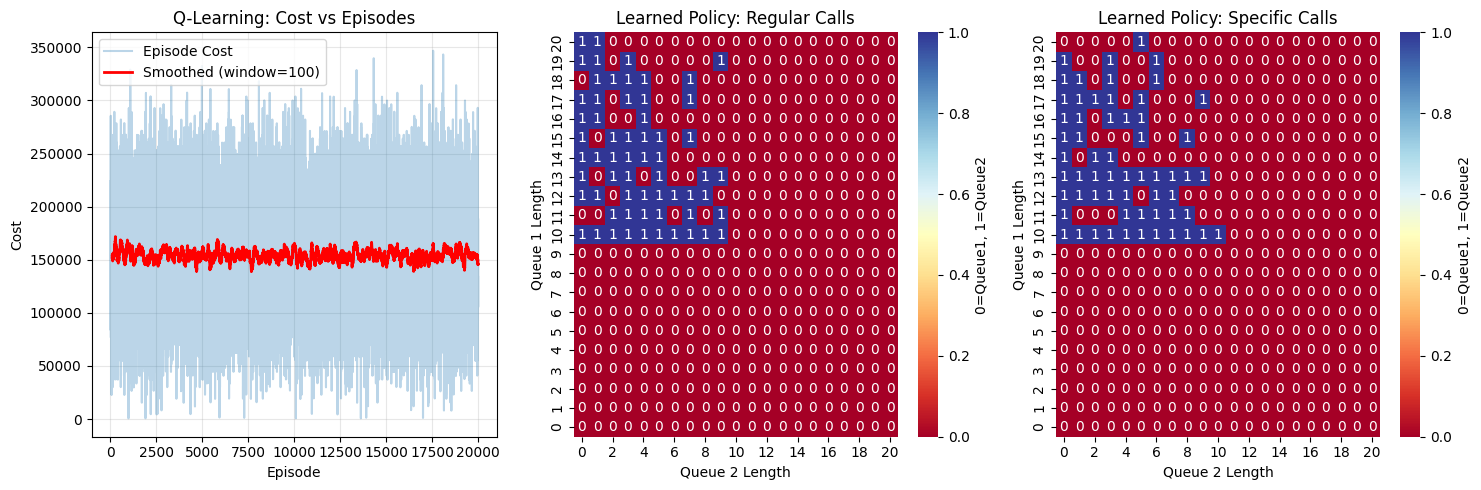

In [110]:
plot_results(costs, Q_table, max_queue_size)

In [118]:
def improved_q_learning(
    env,
    num_episodes=20000,
    max_steps_per_episode=100,
    alpha=0.1,  # Lower learning rate for stability
    gamma=0.99, # High discount for long-term thinking
    epsilon_start=0.9,
    epsilon_min=0.05,
    epsilon_decay=0.9995
):
    """
    Improved Q-learning specifically optimized for the call centre environment.
    Includes better exploration, stability, and monitoring.
    """
    
    # Initialize Q-table with small random values to break ties
    Q = defaultdict(lambda: np.random.normal(0, 0.01, 2))
    
    episode_costs = []
    episode_rewards = []
    optimal_action_counts = []
    epsilon = epsilon_start
    
    # Track learning progress
    learning_stats = {
        'states_visited': defaultdict(int),
        'total_decisions': 0,
        'optimal_decisions': 0
    }
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        state_tuple = tuple(state)
        total_reward = 0
        total_cost = 0
        optimal_actions = 0
        total_actions = 0
        
        for step in range(max_steps_per_episode):
            learning_stats['states_visited'][state_tuple] += 1
            
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.choice([0, 1])
                exploration = True
            else:
                action = int(np.argmax(Q[state_tuple]))
                exploration = False
            
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state_tuple = tuple(next_state)
            
            # Track decision quality for analysis
            if info.get('had_call_to_route', False):
                total_actions += 1
                learning_stats['total_decisions'] += 1
                
                # Determine optimal action (lower expected wait = better)
                if info.get('call_type') != 'none':
                    q1, q2, call_type_idx = state_tuple
                    call_type_val = 0 if info['call_type'] == 'regular' else 1
                    
                    # Calculate what the optimal action should have been
                    wait_q1 = env.expected_waiting_time_binomial(0, call_type_val) if q1 < env.max_queue_size else float('inf')
                    wait_q2 = env.expected_waiting_time_binomial(1, call_type_val) if q2 < env.max_queue_size else float('inf')
                    
                    optimal_choice = 0 if wait_q1 <= wait_q2 else 1
                    if action == optimal_choice:
                        optimal_actions += 1
                        learning_stats['optimal_decisions'] += 1
            
            # Q-learning update
            if not (terminated or truncated):
                best_next_action = np.argmax(Q[next_state_tuple])
                td_target = reward + gamma * Q[next_state_tuple][best_next_action]
                td_error = td_target - Q[state_tuple][action]
                
                # Clip TD error to prevent instability
                td_error = np.clip(td_error, -50.0, 50.0)
                Q[state_tuple][action] += alpha * td_error
            else:
                # Terminal state update
                Q[state_tuple][action] += alpha * (reward - Q[state_tuple][action])
            
            state_tuple = next_state_tuple
            total_reward += reward
            total_cost += abs(reward) if reward < 0 else 0
            
            if terminated or truncated:
                break
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_costs.append(total_cost)
        episode_rewards.append(total_reward)
        
        # Track optimal action rate
        optimal_rate = optimal_actions / total_actions if total_actions > 0 else 0
        optimal_action_counts.append(optimal_rate)
        
        # Enhanced logging every 2000 episodes
        if (episode + 1) % 2000 == 0:
            recent_costs = episode_costs[-2000:]
            recent_rewards = episode_rewards[-2000:]
            recent_optimal = optimal_action_counts[-2000:]
            
            # Calculate learning statistics
            well_visited_states = len([s for s, count in learning_stats['states_visited'].items() if count > 10])
            overall_optimal_rate = learning_stats['optimal_decisions'] / max(learning_stats['total_decisions'], 1)
            
            print(f"\nEpisode {episode+1}/{num_episodes}")
            print(f"  Avg Cost (last 2000): {np.mean(recent_costs):.2f} ± {np.std(recent_costs):.2f}")
            print(f"  Avg Reward (last 2000): {np.mean(recent_rewards):.2f}")
            print(f"  Optimal Action Rate (recent): {np.mean(recent_optimal):.3f}")
            print(f"  Optimal Action Rate (overall): {overall_optimal_rate:.3f}")
            print(f"  Epsilon: {epsilon:.4f}")
            print(f"  States with >10 visits: {well_visited_states}/{len(learning_stats['states_visited'])}")
            print(f"  Total Q-table states: {len(Q)}")
            
            # Sample some Q-values for inspection
            if len(Q) > 0:
                print(f"  Sample Q-values:")
                sample_states = list(Q.keys())[:5]
                for s in sample_states:
                    q_vals = Q[s]
                    preference = "Q1" if q_vals[0] > q_vals[1] else "Q2"
                    diff = abs(q_vals[0] - q_vals[1])
                    print(f"    State{s}: Q1={q_vals[0]:6.2f}, Q2={q_vals[1]:6.2f}, Diff={diff:5.2f} -> {preference}")
    
    # Final summary
    print(f"\n{'='*60}")
    print("LEARNING SUMMARY:")
    print(f"Final optimal action rate: {learning_stats['optimal_decisions'] / max(learning_stats['total_decisions'], 1):.3f}")
    print(f"States explored: {len(Q)}")
    print(f"Well-visited states (>10 visits): {len([s for s, c in learning_stats['states_visited'].items() if c > 10])}")
    print(f"Average cost (last 1000): {np.mean(episode_costs[-1000:]):.2f}")
    print(f"Final epsilon: {epsilon:.4f}")
    
    return Q, episode_costs, episode_rewards, optimal_action_counts

env = CallCentreMDPEnv(
        max_queue_size=max_queue_size,
        drop_penalty=drop_penalty,
        time_step=10.0,  # 10 second time step
        scaler = scaler,  # Scale arrival times for more frequent arrivals
        arrival_regular_mean=arrival_means[0],
        arrival_specific_mean=arrival_means[1],
        service_regular_1=service_means[(1, 0)],
        service_specific_1=service_means[(1, 1)],
        service_regular_2=service_means[(2, 0)],
        service_specific_2=service_means[(2, 1)],
    )

# Usage example:
Q_table, costs, rewards, optimal_rates = improved_q_learning(
    env,
    num_episodes=20000,
    max_steps_per_episode=100,
    alpha=0.1,
    epsilon_start=0.9,
    epsilon_min=0.05,
    epsilon_decay=0.9995
)

Time step: 10.0 seconds
Scaler: 2.0
Scaled arrival means: Regular=20.0s, Specific=49.7s
Arrival rates: Regular=0.0499/s, Specific=0.0201/s
Service means: Q1(R/S)=12.6/14.2s, Q2(R/S)=19.0/15.0s
Expected arrivals per 100 steps: Regular=49.91, Specific=20.13, Total=70.05
Completion probabilities per step:
  (1, 'regular'): 0.2000
  (1, 'specific'): 0.2000
  (2, 'regular'): 0.2000
  (2, 'specific'): 0.2000

Episode 2000/20000
  Avg Cost (last 2000): 7478.60 ± 11720.27
  Avg Reward (last 2000): -7478.60
  Optimal Action Rate (recent): 0.351
  Optimal Action Rate (overall): 0.352
  Epsilon: 0.3310
  States with >10 visits: 854/880
  Total Q-table states: 880
  Sample Q-values:
    State(np.int32(0), np.int32(0), np.int32(1)): Q1=-74.92, Q2=-74.76, Diff= 0.15 -> Q2
    State(np.int32(1), np.int32(0), np.int32(0)): Q1=-79.18, Q2=-79.13, Diff= 0.05 -> Q2
    State(np.int32(2), np.int32(0), np.int32(0)): Q1=-82.16, Q2=-82.81, Diff= 0.65 -> Q1
    State(np.int32(2), np.int32(0), np.int32(1)): Q1=

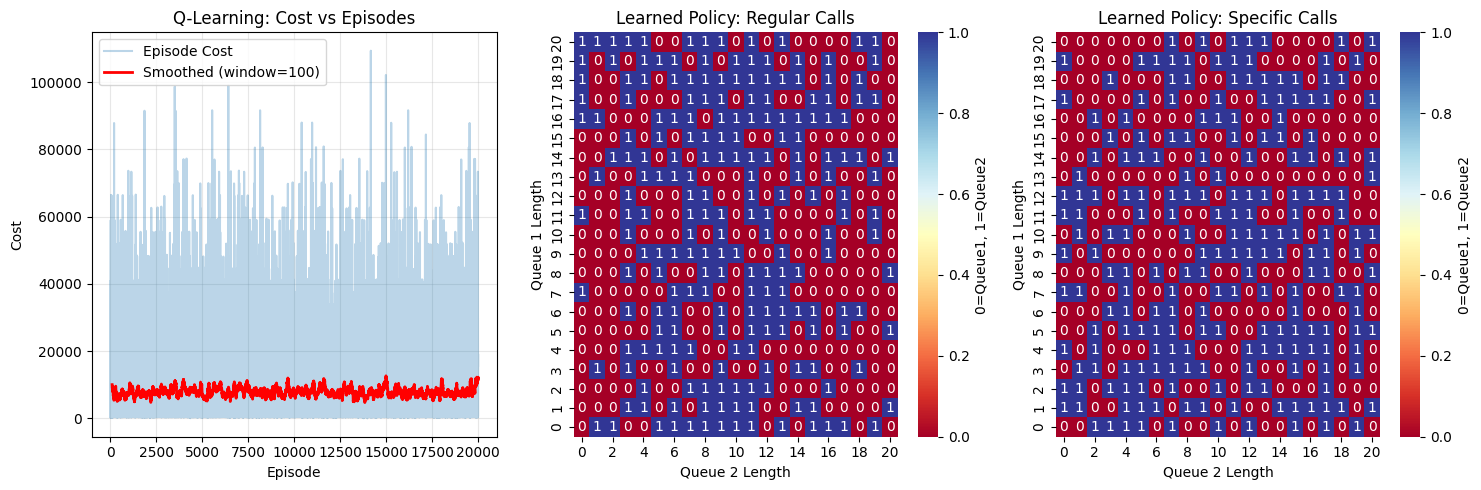

In [119]:
plot_results(costs, Q_table, max_queue_size)

### What to implement next:

* Implement Gym Environment
* Implement Q-Learning
* Implement PPO